source: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #efficient gradient dscents

from PIL import Image
import matplotlib.pyplot as plt #load and display image

import torchvision.transforms as transforms #transform PIL images into tensors
import torchvision.models as models #train or load pre-trained models
import copy # to deep copy the models


Neural Transfer:

$D_C$ measures the distance of content between images, or measures how different two images are in terms of content

$D_S$ measures the distance of style between images, or measures how different two images are in terms of style

We have a simple goal: given a content image and a style image, generate a new image that minimizes the both $D_S$ and $D_C$

In [104]:
#neural transfor algorithms with take longer to run on big images, 
#use GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [119]:
imsize = 512 if torch.cuda.is_available() else 128

In [106]:
loader = transforms.Compose([
    transforms.Resize(imsize), # scale imorted image
    transforms.ToTensor()  #transforms it into a torch tensor
])

In [107]:
def image_loader(image_name):
    image = Image.open(image_name)
    #fake batch dimension required to fit network's input dimensions
    image =loader(image).unsqueeze(0)
    return image.to(device, torch.float)

basewidth = 600
img = Image.open('./images/Van_style.jpg')

print(img.size)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
hsize = 600
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('./images/Van_style.jpg') 

basewidth = 600
img2 = Image.open('./images/Portrait_content.jpeg')

print(img2.size)
wpercent = (basewidth/float(img2.size[0]))
hsize = int((float(img2.size[1])*float(wpercent)))
hsize = 600
img2 = img2.resize((basewidth,hsize), Image.ANTIALIAS)
img2.save('./images/Portrait_content.jpeg') 

style_img = image_loader('./images/Van_style.jpg')
content_img = image_loader('./images/Portrait_content.jpeg')

print(style_img.size())
print(content_img.size())



assert style_img.size() == content_img.size(), \
    'style and content image need to be of the same size'

(600, 600)
(600, 600)
torch.Size([1, 3, 300, 300])
torch.Size([1, 3, 300, 300])


In [108]:
#info 
style_img

tensor([[[[0.3098, 0.3137, 0.3255,  ..., 0.4039, 0.4039, 0.4039],
          [0.3216, 0.3216, 0.3333,  ..., 0.4039, 0.4039, 0.4039],
          [0.3451, 0.3412, 0.3451,  ..., 0.4157, 0.4157, 0.4157],
          ...,
          [0.4784, 0.4784, 0.4824,  ..., 0.3725, 0.3765, 0.3765],
          [0.5098, 0.5098, 0.5137,  ..., 0.4157, 0.4196, 0.4196],
          [0.5216, 0.5255, 0.5255,  ..., 0.4314, 0.4353, 0.4353]],

         [[0.3569, 0.3608, 0.3686,  ..., 0.4510, 0.4510, 0.4510],
          [0.3686, 0.3686, 0.3765,  ..., 0.4471, 0.4471, 0.4471],
          [0.3882, 0.3843, 0.3843,  ..., 0.4510, 0.4510, 0.4510],
          ...,
          [0.4196, 0.4196, 0.4196,  ..., 0.3333, 0.3373, 0.3373],
          [0.4510, 0.4510, 0.4510,  ..., 0.3765, 0.3804, 0.3804],
          [0.4627, 0.4627, 0.4627,  ..., 0.3922, 0.3961, 0.3961]],

         [[0.2627, 0.2667, 0.2745,  ..., 0.3647, 0.3647, 0.3647],
          [0.2745, 0.2745, 0.2824,  ..., 0.3608, 0.3608, 0.3608],
          [0.2941, 0.2902, 0.2902,  ..., 0

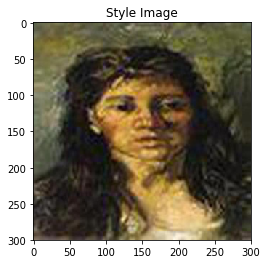

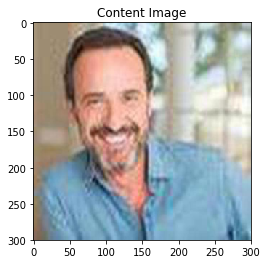

In [109]:
#info see if image was imported correctly by reverting from PIL format to 
#normal image
unloader = transforms.ToPILImage()
plt.ion()
def imgshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #pause a bit so that plots are updated
plt.figure()
imgshow(style_img, title="Style Image")

plt.figure()
imgshow(content_img, title="Content Image")

In [110]:
#Content loss function is defined as the $squared mean error$ between 
#two sets of feature maps of content image and destination image
#use torch.nn.MSELoss

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [111]:
#style loss
def gram_matrix(input):
    a, b, c, d = input.size()
    #a is batch size, b is num of feature maps, (c, d)=dimensions of a f. map (N=c*d)
    
    features = input.view(a* b, c * d) 
    
    G = torch.mm(features, features.t())
    
    #normalize the values of gram matrix by dividing num of elements in each f. map
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
        

In [112]:
# import a pre-trained neural network. We will use a 19 layer VGG network
# Caffee VGG19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [113]:
#VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

In [114]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_2', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [115]:
#Next, we select the input image. You can use a copy of the content image or white noise.
input_img = content_img.clone()


In [116]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [117]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=200,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 118.794884 Content Loss: 13.664689

run [100]:
Style Loss : 85.323593 Content Loss: 15.186851

run [150]:
Style Loss : 66.044350 Content Loss: 19.754053

run [200]:
Style Loss : 74.762589 Content Loss: 25.266729



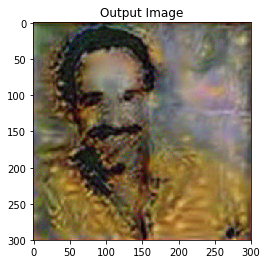

In [118]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()